In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [3]:
os.getcwd()

'/Users/chance/Desktop/LH_home/ksc'

In [4]:
folder = os.listdir()

file = []
for f in folder:
    if "단독다가구" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)

gajwa = pd.concat(file)
gajwa = gajwa.dropna(axis=0)

# 도로조건을 정수로 변환
road=[]
for a in gajwa["도로조건"]:
    if a=="-":
        a = "0"
    road.append(int(a.split("m")[0]))
gajwa["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in gajwa["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

gajwa["year"] = year
gajwa["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in gajwa["건축년도"]]
gajwa["건축년도"] = built_day


#원핫인코딩으로 전월세 구분하기
gajwa = pd.get_dummies(gajwa, columns = ["전월세구분"])
#gajwa = pd.get_dummies(gajwa, columns = ["도로명"])

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./지역별_전월세전환율_20221112193907.csv", encoding="cp949")
rate = rate.T
rate = rate[2:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

gajwa = pd.merge(left=gajwa, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in gajwa["보증금(만원)"]]
gajwa["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(gajwa["월세(만원)"][i] * 12 / (gajwa["전월세전환율"][i]/100) + gajwa["보증금(만원)"][i]) for i in range(len(gajwa))]
gajwa["전세전환가격"] = value
#gajwa["도로별 전세값평균"] = gajwa.groupby("도로명").전세전환가격.transform("mean")

gajwa

,시군구,번지,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,year,month,전월세구분_월세,전월세구분_전세,전월세전환율,전세전환가격
0,경상남도 진주시 가좌동,1***,8,12.00,202001,19,200,36,2019,가좌길60번길,2020,1,1,0,7.0,6371
1,경상남도 진주시 가좌동,1***,8,16.00,202001,22,4000,0,2015,가좌길78번길,2020,1,0,1,7.0,4000
2,경상남도 진주시 가좌동,1***,12,17.00,202001,13,6000,5,2019,가좌길36번길,2020,1,1,0,7.0,6857
3,경상남도 진주시 가좌동,1***,8,20.00,202001,2,300,35,2016,가좌길48번길,2020,1,1,0,7.0,6300
4,경상남도 진주시 가좌동,4**,12,20.00,202001,2,500,40,2014,개양로6번길,2020,1,1,0,7.0,7357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,경상남도 진주시 호탄동,6**,8,42.90,202011,25,7500,0,2018,호탄길9번길,2020,11,0,1,6.6,7500
2507,경상남도 진주시 호탄동,9**,12,50.00,202011,10,5000,30,2011,가호로61번길,2020,11,1,0,6.6,10455
2508,경상남도 진주시 호탄동,6**,8,50.00,202011,18,9000,0,2018,호탄길9번길,2020,11,0,1,6.6,9000
2509,경상남도 진주시 호탄동,9**,25,58.63,202011,14,4000,30,2016,가호로,2020,11,1,0,6.6,9455


In [5]:
# # 전세 월세 구분 데이터셋
# gajwa = gajwa[gajwa.전월세구분 == "월세"]
# gajwa = pd.DataFrame.drop(gajwa, columns=["전월세구분"], axis=1)
# gajwa

In [42]:
# 도로명 결측치 제거

indexNames = []
for i in range(len(gajwa["도로명"])):
    if "번길" not in gajwa["도로명"][i]:
        indexNames.append(i)

gajwa.drop(indexNames, inplace=True)



indexNames2 = []
for i in range(len(gajwa["시군구"])):
    if "호탄동" in gajwa["시군구"][i]:
        indexNames2.append(i)

gajwa.drop(indexNames2, inplace=True)
gajwa

KeyError: 15

In [37]:
gajwa_data = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "도로명", "계약일", "보증금(만원)", "월세(만원)", "전월세전환율"], axis=1)

gajwa_data

,도로조건,계약면적(㎡),건축년도,year,month,전월세구분_월세,전월세구분_전세,전세전환가격
0,8,12.0,2019,2020,1,1,0,6371
1,8,16.0,2015,2020,1,0,1,4000
2,12,17.0,2019,2020,1,1,0,6857
3,8,20.0,2016,2020,1,1,0,6300
4,12,20.0,2014,2020,1,1,0,7357
...,...,...,...,...,...,...,...,...
2504,12,33.0,2002,2020,11,1,0,4282
2506,8,42.9,2018,2020,11,0,1,7500
2507,12,50.0,2011,2020,11,1,0,10455
2508,8,50.0,2018,2020,11,0,1,9000


# 머신러닝

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import catboost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
X = gajwa_data.drop(["전세전환가격"], axis=1)
y = gajwa_data['전세전환가격']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

In [23]:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

## 선형회귀분석

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print(f"MSE : {mse:.3f}", f"RMSE: {rmse:.3f}")
print(f"variance score : {r2_score(y_test, y_preds):.3f}")

MSE : 2592895.703 RMSE: 1610.247
variance score : 0.559


In [25]:
lr.fit(X_train_standardized, y_train)
lr.score(X_test_standardized, y_test)

0.5363510225304964

## Ridge

In [26]:
R_model = Ridge()
R_model.fit(X_train, y_train)
print(R_model.score(X_test, y_test))

R_model.fit(X_train_standardized, y_train)
R_model.score(X_test_standardized, y_test)

0.559346857376575


0.5362694044006826

## Lasso

In [27]:
L_model = Lasso(alpha=0.5)
L_model.fit(X_train, y_train)
print(L_model.score(X_test, y_test))

L_model.fit(X_train_standardized, y_train)
L_model.score(X_test_standardized, y_test)

0.5593609835706088


0.5363357664691222

## ElasticNet

In [28]:
ela = ElasticNet(alpha=0.5)
ela.fit(X_train, y_train)
print(ela.score(X_test, y_test))

ela.fit(X_train_standardized, y_train)
ela.score(X_test_standardized, y_test)

0.5419211148711809


0.4915825894654301

## 랜덤포레스트

In [29]:
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
randomforest_model = randomforest.fit(X_train, y_train)
print(randomforest_model.score(X_test, y_test))

randomforest_model = randomforest.fit(X_train_standardized, y_train)
randomforest_model.score(X_test_standardized, y_test)

0.6008427191008144


0.5776010872811675

## 결정 트리 회귀

In [30]:
decisiontree_mae = DecisionTreeRegressor(criterion="mae", random_state=0)
model_mae = decisiontree_mae.fit(X_train, y_train)
model_mae.score(X_test, y_test)

/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/sklearn/tree/_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


0.3946161736543643

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
gbm.fit(X_train_standardized, y_train)
gbm.score(X_test_standardized, y_test)

0.5709587428699352

In [32]:
lightgbm = lgb.LGBMRegressor()
lightgbm.fit(X_train_standardized, y_train)
lightgbm.score(X_test_standardized, y_test)

0.5802103627416841

In [33]:
xgboost = XGBRegressor(n_estimators=30)
xgboost.fit(X_train, y_train)
print(xgboost.score(X_test, y_test))

xgboost.fit(X_train_standardized, y_train)
xgboost.score(X_test_standardized, y_test)

0.5807634453117962


/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.5113392986624907

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

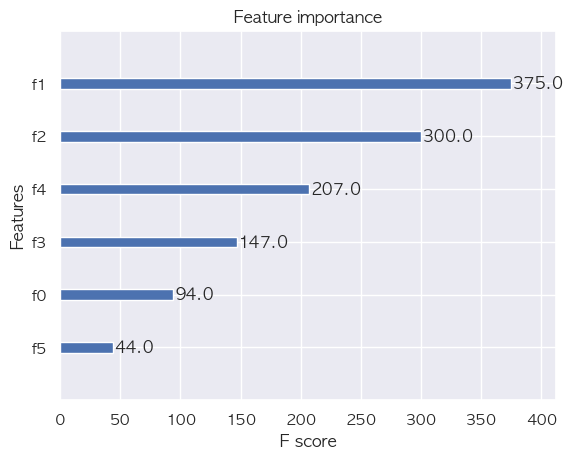

In [34]:
plot_importance(xgboost)

In [35]:
cb = catboost.CatBoostRegressor()
cb.fit(X_train_standardized, y_train)
cb.score(X_test_standardized, y_test)

Learning rate set to 0.044594
0:	learn: 2050.5449410	total: 61.9ms	remaining: 1m 1s
1:	learn: 2010.3956989	total: 62.4ms	remaining: 31.1s
2:	learn: 1967.3777796	total: 63ms	remaining: 20.9s
3:	learn: 1928.6617481	total: 63.5ms	remaining: 15.8s
4:	learn: 1890.1651261	total: 63.8ms	remaining: 12.7s
5:	learn: 1854.0936169	total: 64.3ms	remaining: 10.7s
6:	learn: 1819.1818383	total: 64.7ms	remaining: 9.18s
7:	learn: 1789.9790856	total: 65.2ms	remaining: 8.09s
8:	learn: 1760.3298577	total: 65.7ms	remaining: 7.23s
9:	learn: 1730.7872215	total: 66.2ms	remaining: 6.55s
10:	learn: 1708.7563224	total: 66.6ms	remaining: 5.99s
11:	learn: 1684.1229954	total: 67ms	remaining: 5.52s
12:	learn: 1662.5324349	total: 67.5ms	remaining: 5.13s
13:	learn: 1638.0831965	total: 68ms	remaining: 4.79s
14:	learn: 1616.9715296	total: 68.5ms	remaining: 4.5s
15:	learn: 1596.9019462	total: 69ms	remaining: 4.24s
16:	learn: 1575.6828135	total: 69.6ms	remaining: 4.02s
17:	learn: 1556.4096387	total: 70ms	remaining: 3.82s
1

0.5738517935165238

## 데이터시각화

In [26]:
corr = gajwa_data.corr()
corr

,도로조건,계약면적(㎡),건축년도,year,month,전월세구분_월세,전월세구분_전세,전세전환가격
도로조건,1.000000,0.085421,-0.074144,0.021331,-0.008826,0.102685,-0.102685,0.120568
계약면적(㎡),0.085421,1.000000,-0.118676,-0.069326,0.079152,-0.041987,0.041987,0.672994
건축년도,-0.074144,-0.118676,1.000000,0.103596,-0.044739,-0.122325,0.122325,0.029346
year,0.021331,-0.069326,0.103596,1.000000,-0.296099,0.015781,-0.015781,-0.027950
month,-0.008826,0.079152,-0.044739,-0.296099,1.000000,-0.028657,0.028657,0.074396
전월세구분_월세,0.102685,-0.041987,-0.122325,0.015781,-0.028657,1.000000,-1.000000,0.248415
전월세구분_전세,-0.102685,0.041987,0.122325,-0.015781,0.028657,-1.000000,1.000000,-0.248415
전세전환가격,0.120568,0.672994,0.029346,-0.027950,0.074396,0.248415,-0.248415,1.000000


## 카카오맵api

In [377]:
import folium
long = []
lat = []

m = folium.Map(location=[35.1551364, 128.1088764], zoom_start=18)
folium.Marker([35.1551364, 128.1088764]).add_to(m)
m